In [1]:
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import warnings
import random

from scipy.stats import kurtosis, skew

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.preprocessing import RobustScaler, StandardScaler, QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc

import shap
import joblib

/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

In [4]:
warnings.filterwarnings("ignore")
plt.style.use('tableau-colorblind10')

## Dataset

In [5]:
# Reading Train data
full_train_data = pl.read_csv("../data/merged_cleaned_insurance_data.csv")

In [6]:
full_train_data.head()

Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,Claim_Duration,Admitted_Duration,AGE,Att_Opr_Oth_Phy_Tot_Claims,Prv_Tot_Att_Opr_Oth_Phys,PRV_Tot_Admit_DCodes,PRV_Tot_DGrpCodes,PRV_Tot_Unq_DOB_Years,PRV_Bene_Age_Sum,PRV_Insc_Clm_ReImb_Amt,PRV_Tot_RKD_Patients,PRV_IP_Annual_ReImb_Amt,PRV_IP_Annual_Ded_Amt,PRV_OP_Annual_ReImb_Amt,PRV_OP_Annual_Ded_Amt,PRV_Admit_Duration,PRV_Claim_Duration,BENE_Insc_ReImb_Amt,BENE_IP_Annual_ReImb_Amt,BENE_IP_Annual_Ded_Amt,BENE_OP_Annual_ReImb_Amt,BENE_OP_Annual_Ded_Amt,BENE_Admit_Duration,BENE_Claim_Duration,Claim_Admit_Diag_Code_Insc_ReImb_Amt,Claim_Admit_Diag_Code_IP_Annual_ReImb_Amt,Claim_Admit_Diag_Code_IP_Annual_Ded_Amt,Claim_Admit_Diag_Code_OP_Annual_ReImb_Amt,Claim_Admit_Diag_Code_OP_Annual_Ded_Amt,Claim_Admit_Diag_Code_Admit_Duration,Claim_Admit_Diag_Code_Claim_Duration,ClmCount_Provider,ClmCount_Provider_BeneID,ClmCount_Provider_AttendingPhysician,ClmCount_Provider_BeneID_AttendingPhysician,ClmCount_Provider_ClmAdmitDiagnosisCode,Is_Alive?,Gender_1,Race_1,Race_2,Race_3,Race_5,Admitted?_1,Is_Alive_No,Is_Alive_Yes
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""PRV55912""",26000,1068,0,1,0,1,0,0,1,1,1,0,1,1,36000,3204,60,70,1,6,6,67,802240,321,60,57,40,8141,750080,33,1420920,148908,249270,59690,388,469,36000,108000,9612,180,210,11,11,935850,2345220,216260,519910,164950,343,433,107,1,1,1,1,1,1,1,0,0,0,1,0,1
"""PRV55907""",5000,1068,0,1,0,1,0,0,1,1,1,0,1,1,36000,3204,60,70,0,2,2,67,358478,729,82,52,56,17866,598180,59,1946470,204920,608230,171700,346,660,36000,108000,9612,180,210,11,11,15000,46210,6408,6040,1070,5,5,243,1,2,1,1,1,1,1,0,0,0,1,0,1
"""PRV56046""",5000,1068,0,1,0,1,0,0,1,1,1,0,1,1,36000,3204,60,70,0,3,3,67,443774,60,16,15,15,1396,121680,1,366840,33632,24050,4730,72,72,36000,108000,9612,180,210,11,11,414380,1281180,166460,232690,70360,612,890,20,1,5,1,1,1,1,1,0,0,0,1,0,1
"""PRV52405""",5000,1068,0,0,1,1,0,0,1,1,0,0,1,1,5000,1068,250,320,0,8,8,95,41,267,40,23,41,6372,189070,23,656110,65148,251730,88310,88,273,5180,20000,4272,1000,1280,8,8,975790,1503930,151624,100350,34330,460,481,89,1,31,1,1,1,0,0,1,0,0,1,0,1
"""PRV56614""",10000,1068,1,0,1,1,0,1,1,0,1,0,0,0,21260,2136,120,100,0,17,17,71,358481,78,16,16,17,1883,126100,12,311840,33108,103960,28700,102,116,10060,42520,4272,240,200,17,17,202520,654490,67284,241040,75660,61,80,26,1,2,1,1,1,0,1,0,0,0,1,0,1


The goal of this step is to transform our raw claim-level data into provider-level aggregates, because the main objective of our project is to detect Medicare provider fraud and fraud typically happens at the provider level, not the individual claim level.

So what I did was group the dataset by 'Provider' and 'PotentialFraud', and then aggregate all other numerical columns using the sum function. This gives us a compact, n-dimensional representation of each provider, where each row corresponds to a provider and contains total values like total reimbursements, total number of procedures, total claim durations, and so on.

In [7]:
full_train_data = (
    full_train_data
    .group_by(["Provider", "PotentialFraud"])
    .agg([
        pl.col("*").exclude(["Provider", "PotentialFraud"]).sum()
    ])
)

In [8]:
print(f"full_train_data.shape: {full_train_data.shape}")

full_train_data.shape: (5410, 65)


### Train Test Split

In [9]:
X = full_train_data.drop(['Provider', 'PotentialFraud'])

y = full_train_data.select('PotentialFraud')

X_shape = X.shape
y_shape = y.shape
X_type = type(X)
y_type = type(y)

print(X_shape, X_type)
print(y_shape, y_type)

(5410, 63) <class 'polars.dataframe.frame.DataFrame'>
(5410, 1) <class 'polars.dataframe.frame.DataFrame'>


In [10]:
print(X.head())
print(y.head())

shape: (5, 63)
┌────────────┬────────────┬───────────┬───────────┬───┬────────┬───────────┬───────────┬───────────┐
│ InscClaimA ┆ Deductible ┆ RenalDise ┆ ChronicCo ┆ … ┆ Race_5 ┆ Admitted? ┆ Is_Alive_ ┆ Is_Alive_ │
│ mtReimburs ┆ AmtPaid    ┆ aseIndica ┆ nd_Alzhei ┆   ┆ ---    ┆ _1        ┆ No        ┆ Yes       │
│ ed         ┆ ---        ┆ tor       ┆ mer       ┆   ┆ i64    ┆ ---       ┆ ---       ┆ ---       │
│ ---        ┆ i64        ┆ ---       ┆ ---       ┆   ┆        ┆ i64       ┆ i64       ┆ i64       │
│ i64        ┆            ┆ i64       ┆ i64       ┆   ┆        ┆           ┆           ┆           │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪════════╪═══════════╪═══════════╪═══════════╡
│ 115670     ┆ 6558       ┆ 19        ┆ 37        ┆ … ┆ 0      ┆ 6         ┆ 0         ┆ 59        │
│ 26220      ┆ 270        ┆ 16        ┆ 31        ┆ … ┆ 0      ┆ 0         ┆ 0         ┆ 77        │
│ 540810     ┆ 17854      ┆ 280       ┆ 552       ┆ … ┆ 27     ┆ 13        ┆

In [11]:
X_pd = X.to_pandas()
y_pd = y.to_pandas().squeeze()

X_train, X_test, y_train, y_test = train_test_split(
    X_pd, y_pd,
    test_size=0.20,
    stratify=y_pd,
    random_state=39
)


print("SHAPES:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

print("\nTARGET DISTRIBUTION IN y_train:")
print(y_train.value_counts())

print("\nTARGET DISTRIBUTION IN y_test:")
print(y_test.value_counts())

SHAPES:
X_train: (4328, 63)
X_test: (1082, 63)
y_train: (4328,)
y_test: (1082,)

TARGET DISTRIBUTION IN y_train:
PotentialFraud
0    3923
1     405
Name: count, dtype: int64

TARGET DISTRIBUTION IN y_test:
PotentialFraud
0    981
1    101
Name: count, dtype: int64


### Scaling

In [12]:
robust_scaler = RobustScaler()
X_train_std = robust_scaler.fit_transform(X_train)
X_test_std = robust_scaler.transform(X_test)

X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std = pd.DataFrame(X_test_std, columns=X_train.columns)

In [13]:
counter = Counter(y_train)
print(f"Before SMOTE class distribution: {counter}")

fraud_percentage = (counter[1] * 100) / (counter[0] + counter[1])
non_fraud_percentage = (counter[0] * 100) / (counter[0] + counter[1])
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Before SMOTE class distribution: Counter({0: 3923, 1: 405})
Fraud Percentage = 9.36% and Non-Fraud Percentage = 90.64%


In [14]:
if fraud_percentage < 20:
    smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
    X_train_ovsamp, y_train_ovsamp = smote.fit_resample(X_train_std, y_train)

    counter = Counter(y_train_ovsamp)
    print(f"After SMOTE class distribution: {counter}")

    fraud_percentage = (counter[1] * 100) / (counter[0] + counter[1])
    non_fraud_percentage = (counter[0] * 100) / (counter[0] + counter[1])
    print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))
else:
    print("SMOTE not applied because class imbalance is acceptable.")
    X_train_ovsamp, y_train_ovsamp = X_train_std, y_train

After SMOTE class distribution: Counter({0: 3923, 1: 3923})
Fraud Percentage = 50.00% and Non-Fraud Percentage = 50.00%


In [15]:
class FraudModelEvaluator:
    def __init__(self, model: BaseEstimator):
        """
        Initialize with any sklearn-compatible classifier that supports predict_proba().
        """
        self.model = model
        self.best_threshold = 0.5
        self.y_train_pred_proba = None
        self.y_test_pred_proba = None
        self.y_train_pred = None
        self.y_test_pred = None
        self.train_fpr = None
        self.train_tpr = None
        self.test_fpr = None
        self.test_tpr = None

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def pred_proba(self, X):
        return self.model.predict_proba(X)[:, 1]

    def find_best_threshold(self, fpr, tpr, thresholds):
        return thresholds[np.argmax(tpr * (1 - fpr))]

    def predict_with_threshold(self, proba, threshold):
        return [1 if p >= threshold else 0 for p in proba]

    def evaluate(self, X_train, X_test, y_train, y_test):
        self.y_train_pred_proba = self.pred_proba(X_train)
        self.y_test_pred_proba = self.pred_proba(X_test)

        self.train_fpr, self.train_tpr, train_thresh = roc_curve(y_train, self.y_train_pred_proba)
        self.test_fpr, self.test_tpr, _ = roc_curve(y_test, self.y_test_pred_proba)

        self.best_threshold = self.find_best_threshold(self.train_fpr, self.train_tpr, train_thresh)

        self.y_train_pred = self.predict_with_threshold(self.y_train_pred_proba, self.best_threshold)
        self.y_test_pred = self.predict_with_threshold(self.y_test_pred_proba, self.best_threshold)

        train_auc = auc(self.train_fpr, self.train_tpr)
        test_auc = auc(self.test_fpr, self.test_tpr)
        train_f1 = f1_score(y_train, self.y_train_pred)
        test_f1 = f1_score(y_test, self.y_test_pred)

        print(f"Best Threshold      : {self.best_threshold:.4f}")
        print(f"Train AUC           : {train_auc:.4f}")
        print(f"Test AUC            : {test_auc:.4f}")
        print(f"Train F1 Score      : {train_f1:.4f}")
        print(f"Test F1 Score       : {test_f1:.4f}")

        return {
            "best_threshold": self.best_threshold,
            "train_auc": train_auc,
            "test_auc": test_auc,
            "train_f1": train_f1,
            "test_f1": test_f1
        }

    def plot_roc(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_fpr, self.train_tpr, label=f"Train AUC = {auc(self.train_fpr, self.train_tpr):.4f}")
        plt.plot(self.test_fpr, self.test_tpr, label=f"Test AUC = {auc(self.test_fpr, self.test_tpr):.4f}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.legend()
        plt.show()

    def plot_confusion_matrices(self, y_train, y_test):
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        cm_train = confusion_matrix(y_train, self.y_train_pred)
        cm_test = confusion_matrix(y_test, self.y_test_pred)

        sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax[0])
        ax[0].set_title("Train Confusion Matrix")
        ax[0].set_xlabel("Predicted")
        ax[0].set_ylabel("Actual")

        sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=ax[1])
        ax[1].set_title("Test Confusion Matrix")
        ax[1].set_xlabel("Predicted")
        ax[1].set_ylabel("Actual")

        plt.tight_layout()
        plt.show()

### Logistic Regression

In [16]:
def tune_logistic_regression(X, y):
    param_grid = {
        'C': [0.05, 0.1, 0.5, 1.0],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
    }

    grid_search = GridSearchCV(
        LogisticRegression(random_state=42),
        param_grid,
        cv=5,
        scoring='f1',
        n_jobs=1,
        verbose=1
    )
    
    grid_search.fit(X, y)
    print("Best Params:", grid_search.best_params_)
    return grid_search.best_estimator_

In [17]:
best_log_model = tune_logistic_regression(X_train_ovsamp, y_train_ovsamp)

evaluator_lr = FraudModelEvaluator(best_log_model)
evaluator_lr.train(X_train_ovsamp, y_train_ovsamp)
evaluator_lr.evaluate(X_train_ovsamp, X_test_std, y_train_ovsamp, y_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Params: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Threshold      : 0.3841
Train AUC           : 0.9545
Test AUC            : 0.9337
Train F1 Score      : 0.8909
Test F1 Score       : 0.5610


{'best_threshold': np.float64(0.3840842070804924),
 'train_auc': np.float64(0.954470290278792),
 'test_auc': np.float64(0.9337410805300712),
 'train_f1': 0.8909136927360162,
 'test_f1': 0.5609756097560976}

In [18]:
joblib.dump(best_log_model, "../models/best_logistic_model.pkl")

['../models/best_logistic_model.pkl']

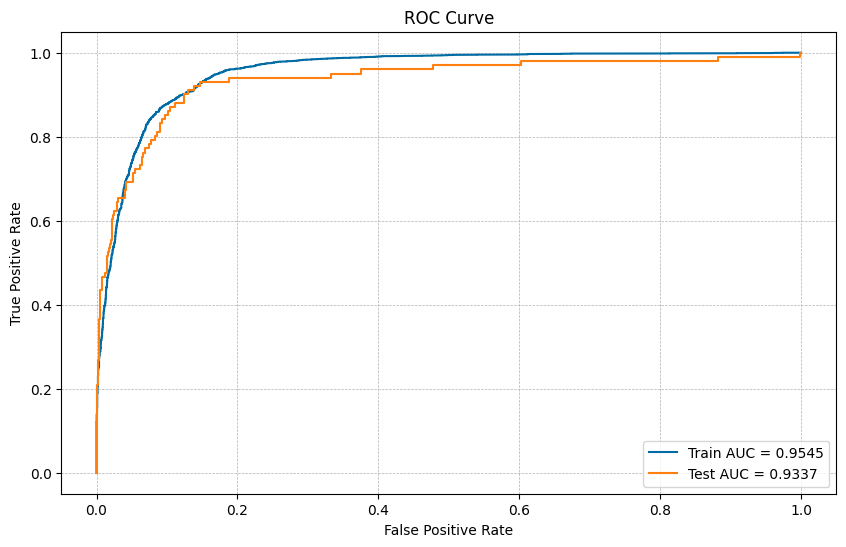

In [19]:
evaluator_lr.plot_roc()

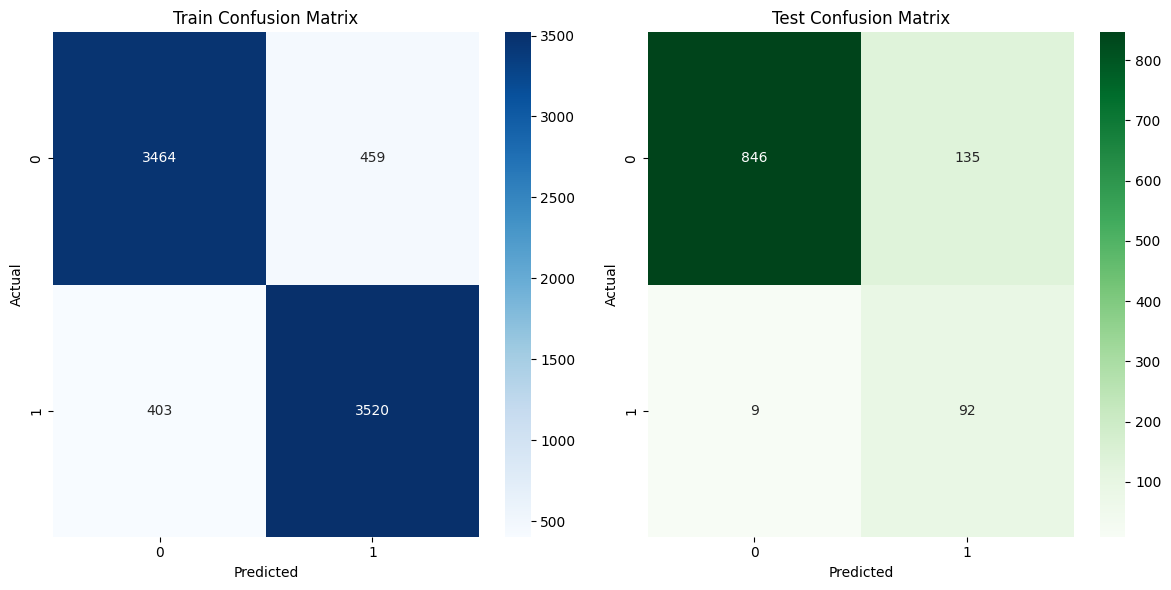

In [20]:
evaluator_lr.plot_confusion_matrices(y_train_ovsamp, y_test)

### Decision Tree

In [21]:
def tune_decision_tree(X, y):
    param_grid = {
        'max_depth': [6, 10],
        'min_samples_split': [100, 150],
        'min_samples_leaf': [100, 150],
        'criterion': ['gini'],
        'max_features': ['log2'],
        'class_weight': ['balanced']
    }

    base_model = DecisionTreeClassifier(
        random_state=42,
        splitter='best',
        min_weight_fraction_leaf=0.0,
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        ccp_alpha=0.0
    )

    grid = GridSearchCV(base_model, param_grid, cv=5, scoring='f1', n_jobs=1)
    grid.fit(X, y)
    print("Best Decision Tree Params:", grid.best_params_)
    return grid.best_estimator_

In [22]:
best_dt_model = tune_decision_tree(X_train_ovsamp, y_train_ovsamp)

evaluator_dt = FraudModelEvaluator(best_dt_model)
evaluator_dt.train(X_train_ovsamp, y_train_ovsamp)
evaluator_dt.evaluate(X_train_ovsamp, X_test_std, y_train_ovsamp, y_test)

Best Decision Tree Params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 100, 'min_samples_split': 100}
Best Threshold      : 0.5125
Train AUC           : 0.9448
Test AUC            : 0.9223
Train F1 Score      : 0.8774
Test F1 Score       : 0.4865


{'best_threshold': np.float64(0.5124555160142349),
 'train_auc': np.float64(0.9448445798547869),
 'test_auc': np.float64(0.9223110384432938),
 'train_f1': 0.8774304700959882,
 'test_f1': 0.4864864864864865}

In [23]:
joblib.dump(best_dt_model, "../models/best_decision_tree_model.pkl")

['../models/best_decision_tree_model.pkl']

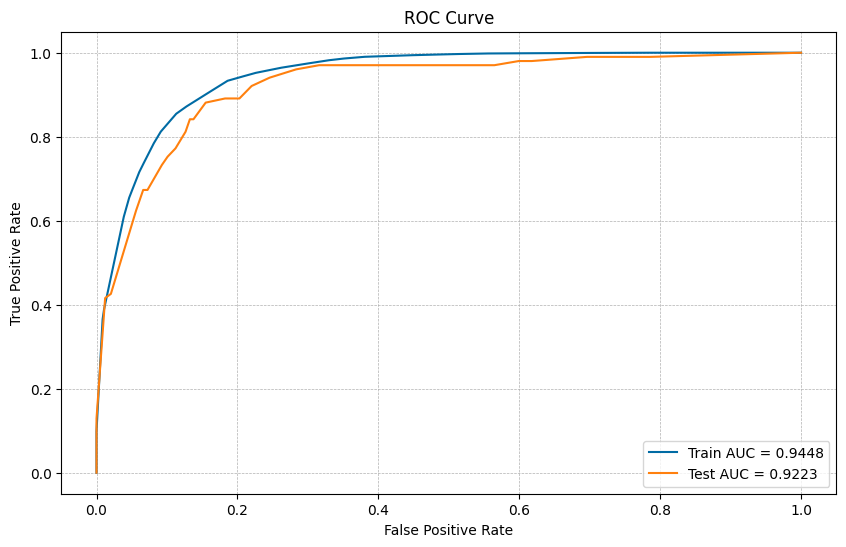

In [24]:
evaluator_dt.plot_roc()

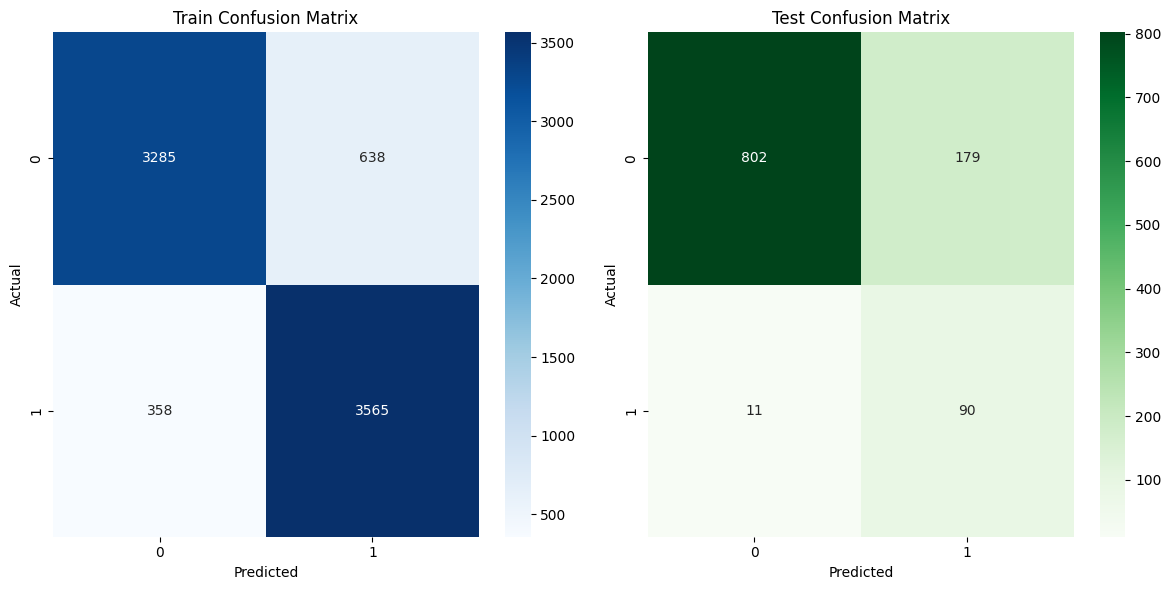

In [25]:
evaluator_dt.plot_confusion_matrices(y_train_ovsamp, y_test)

### Random Forest

In [26]:
def tune_random_forest(X, y):
    param_grid = {
        'max_depth': [4, 6],
        'n_estimators': [30, 50]
    }

    base_model = RandomForestClassifier(
        criterion='gini',
        max_features='sqrt',
        min_samples_leaf=50,
        min_samples_split=50,
        class_weight='balanced',
        random_state=42,
        min_weight_fraction_leaf=0.0,
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        ccp_alpha=0.0,
        bootstrap=True
    )

    search = RandomizedSearchCV(base_model,
                                param_distributions=param_grid,
                                n_iter=30,
                                cv=5,
                                scoring='f1',
                                n_jobs=1,
                                verbose=2)
    search.fit(X, y)
    print("Best Random Forest Params:", search.best_params_)
    return search.best_estimator_

In [27]:
best_rf_model = tune_random_forest(X_train_ovsamp, y_train_ovsamp)

evaluator_rf = FraudModelEvaluator(best_rf_model)
evaluator_rf.train(X_train_ovsamp, y_train_ovsamp)    
evaluator_rf.evaluate(X_train_ovsamp, X_test_std, y_train_ovsamp, y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .......................max_depth=4, n_estimators=30; total time=   0.2s
[CV] END .......................max_depth=4, n_estimators=30; total time=   0.2s
[CV] END .......................max_depth=4, n_estimators=30; total time=   0.2s
[CV] END .......................max_depth=4, n_estimators=30; total time=   0.2s
[CV] END .......................max_depth=4, n_estimators=30; total time=   0.2s
[CV] END .......................max_depth=4, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=4, n_estimators=50; total time=   0.3s
[CV] END .......................max_depth=4, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=4, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=4, n_estimators=50; total time=   0.3s
[CV] END .......................max_depth=6, n_estimators=30; total time=   0.3s
[CV] END .......................max_depth=6, n_es

{'best_threshold': np.float64(0.5701865921645257),
 'train_auc': np.float64(0.9649743673281403),
 'test_auc': np.float64(0.9347705412743109),
 'train_f1': 0.9079832466048992,
 'test_f1': 0.5798045602605864}

In [28]:
joblib.dump(best_rf_model, "../models/best_random_forest_model.pkl")

['../models/best_random_forest_model.pkl']

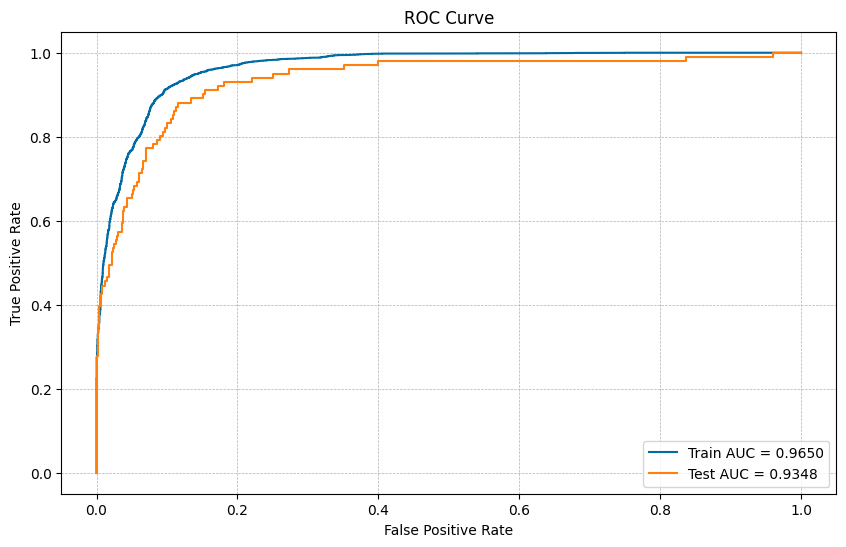

In [29]:
evaluator_rf.plot_roc()

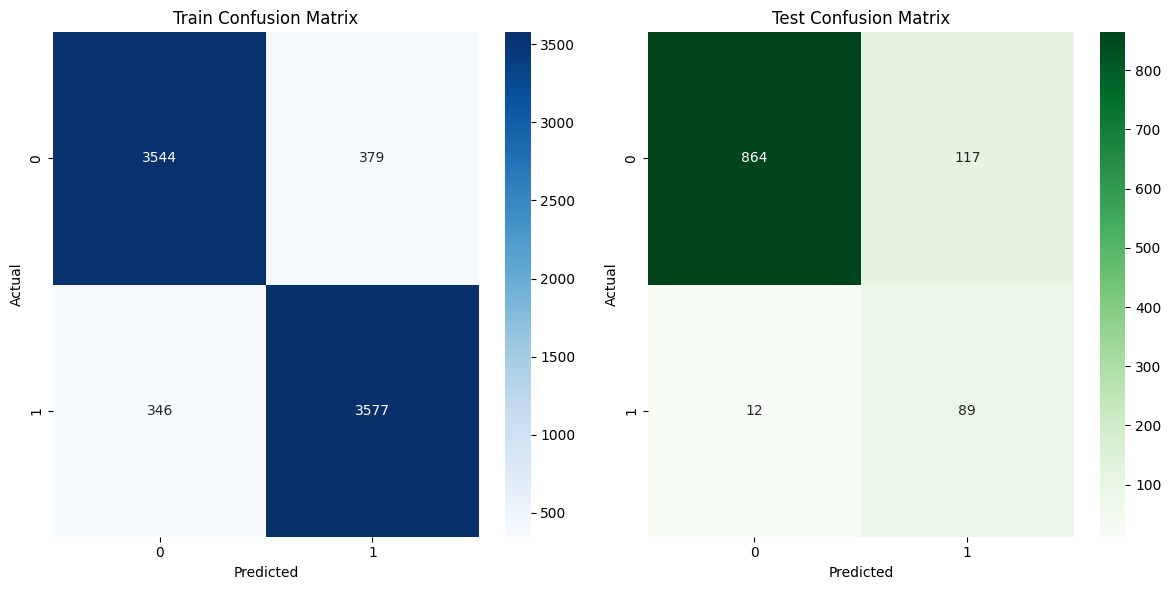

In [30]:
evaluator_rf.plot_confusion_matrices(y_train_ovsamp, y_test)   

#### XGBoost

In [31]:
def tune_xgboost(X, y):
    param_grid = {
        'n_estimators': [100, 150],
        'max_depth': [3, 4],
        'learning_rate': [0.05, 0.1]
    }

    base_model = XGBClassifier(
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=49
    )

    search = RandomizedSearchCV(base_model,
                                param_distributions=param_grid,
                                n_iter=30,
                                cv=5,
                                scoring='f1',
                                n_jobs=11,
                                verbose=2)
    search.fit(X, y)
    print("Best XGBoost Params:", search.best_params_)
    return search.best_estimator_

In [32]:
best_xgb_model = tune_xgboost(X_train_ovsamp, y_train_ovsamp)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encode

[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.5s


/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encode

[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=150; total time=   0.7s


/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encode

[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=150; total time=   0.7s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=150; total time=   0.6s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=150; total time=   0.6s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=100; total time=   0.6s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=150; total time=   0.6s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=100; total time=   0.7s


/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encode

[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=100; total time=   0.6s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=100; total time=   0.6s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=100; total time=   0.7s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.4s


/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encode

[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=150; total time=   0.9s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=150; total time=   0.8s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=150; total time=   0.9s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=150; total time=   0.8s


/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encode

[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=150; total time=   0.8s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=150; total time=   0.5s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=150; total time=   0.5s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=150; total time=   0.3s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=150; total time=   0.5s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=150; total time=   0.3s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=   0.4s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=   0.3s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=   0.3s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=   0.3s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=   0.3s


/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/INFO531/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:57:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=150; total time=   0.4s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=150; total time=   0.4s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=150; total time=   0.3s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=150; total time=   0.4s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=150; total time=   0.4s
Best XGBoost Params: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1}


In [33]:
evaluator_xgb = FraudModelEvaluator(model=best_xgb_model)
evaluator_xgb.train(X_train_ovsamp, y_train_ovsamp)

metrics_xgb = evaluator_xgb.evaluate(X_train_ovsamp, X_test_std, y_train_ovsamp, y_test)

Best Threshold      : 0.5518
Train AUC           : 0.9985
Test AUC            : 0.9305
Train F1 Score      : 0.9834
Test F1 Score       : 0.5607


In [34]:
joblib.dump(best_xgb_model, "../models/best_xgboost_model.pkl")

['../models/best_xgboost_model.pkl']

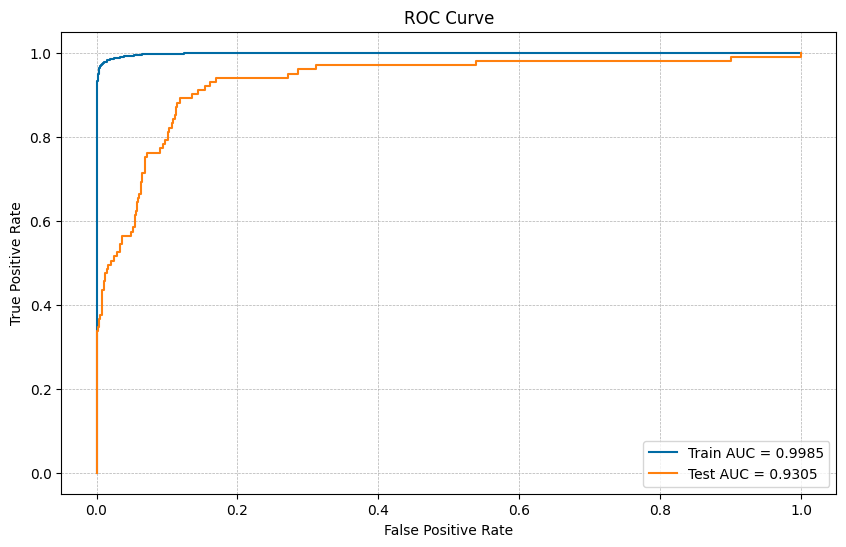

In [35]:
evaluator_xgb.plot_roc()

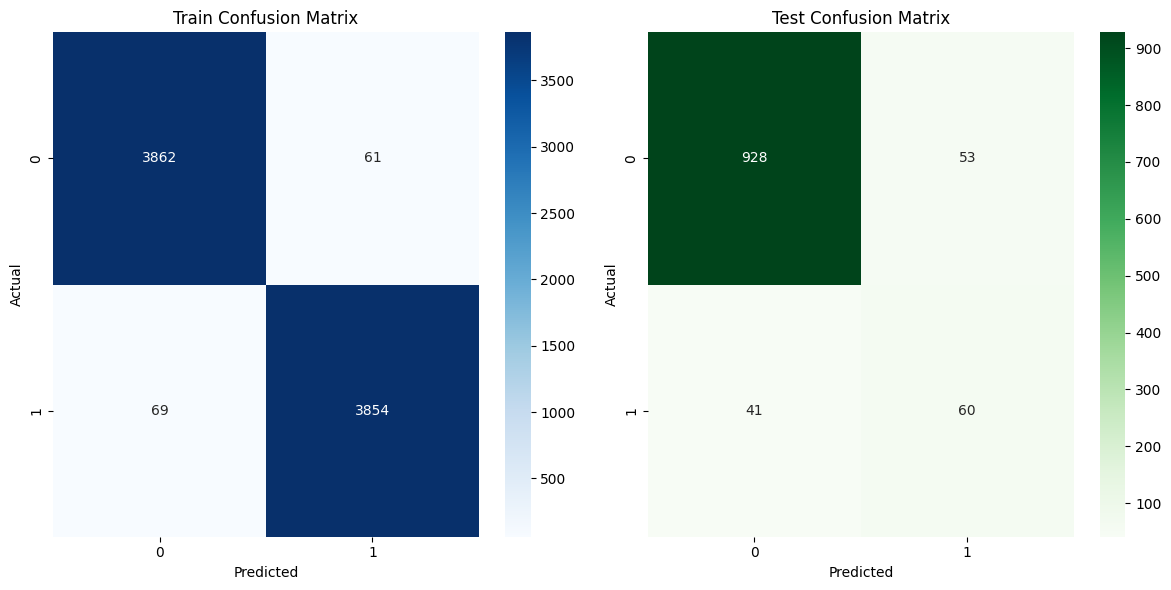

In [36]:
evaluator_xgb.plot_confusion_matrices(y_train_ovsamp, y_test)

#### LightGBM

In [37]:
def tune_lightgbm(X, y):
    param_grid = {
        'n_estimators': [100, 150],
        'learning_rate': [0.05, 0.1],
        'max_depth': [4, 5],
        'num_leaves': [15, 31],
        'min_child_samples': [10, 20]
    }

    base_model = LGBMClassifier(
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42
    )

    search = RandomizedSearchCV(base_model,
                                param_distributions=param_grid,
                                n_iter=30,
                                cv=5,
                                scoring='f1',
                                n_jobs=11,
                                verbose=2)
    search.fit(X, y)
    print("Best LightGBM Params:", search.best_params_)
    return search.best_estimator_

In [38]:
best_lgbm_model = tune_lightgbm(X_train_ovsamp, y_train_ovsamp)
evaluator_lgbm = FraudModelEvaluator(best_lgbm_model)
evaluator_lgbm.train(X_train_ovsamp, y_train_ovsamp)

metrics_lgbm = evaluator_lgbm.evaluate(X_train_ovsamp, X_test_std, y_train_ovsamp, y_test)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 3138, number of negative: 3138
[LightGBM] [Info] Number of positive: 3139, number of negative: 3138
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16065
[LightGBM] [Info] Number of data points in the train set: 6276, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16065
[LightGBM] [Info] Number of data points in the train set: 6277, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500080 -> initscore=0.000319
[LightGBM] [Info] Start training from score 0.000319
[LightGBM] 

In [39]:
joblib.dump(best_lgbm_model, "../models/best_lightgbm_model.pkl")

['../models/best_lightgbm_model.pkl']

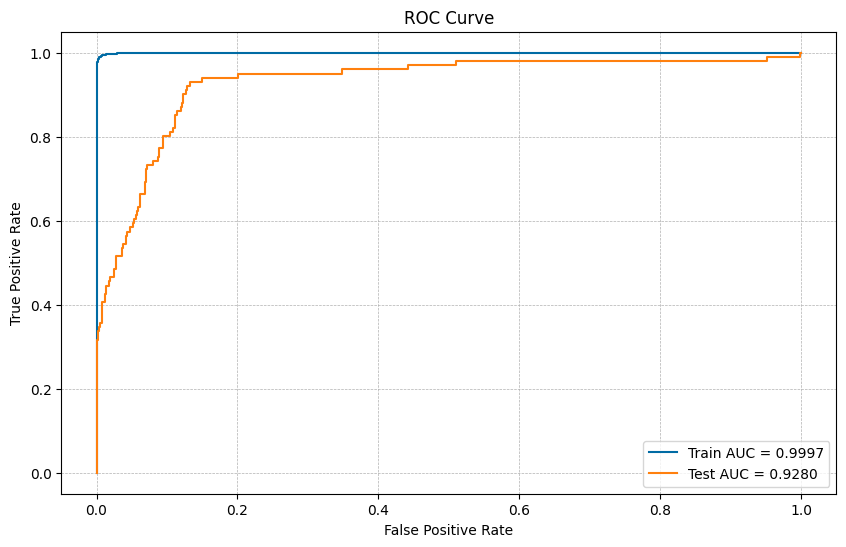

In [40]:
evaluator_lgbm.plot_roc()

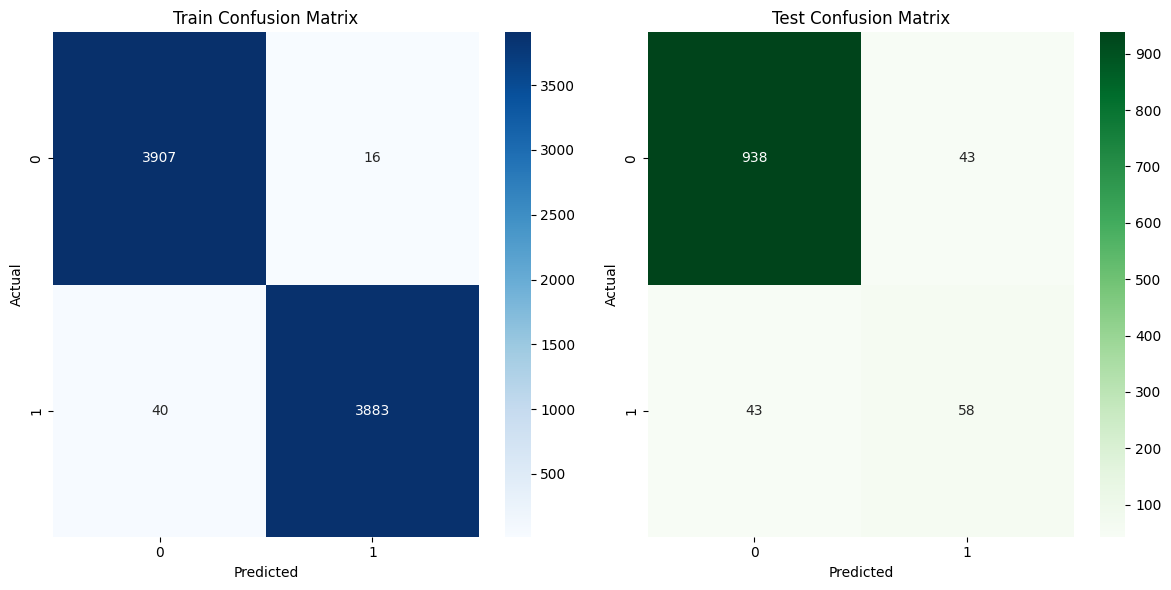

In [41]:
evaluator_lgbm.plot_confusion_matrices(y_train_ovsamp, y_test)

### Feature Importance

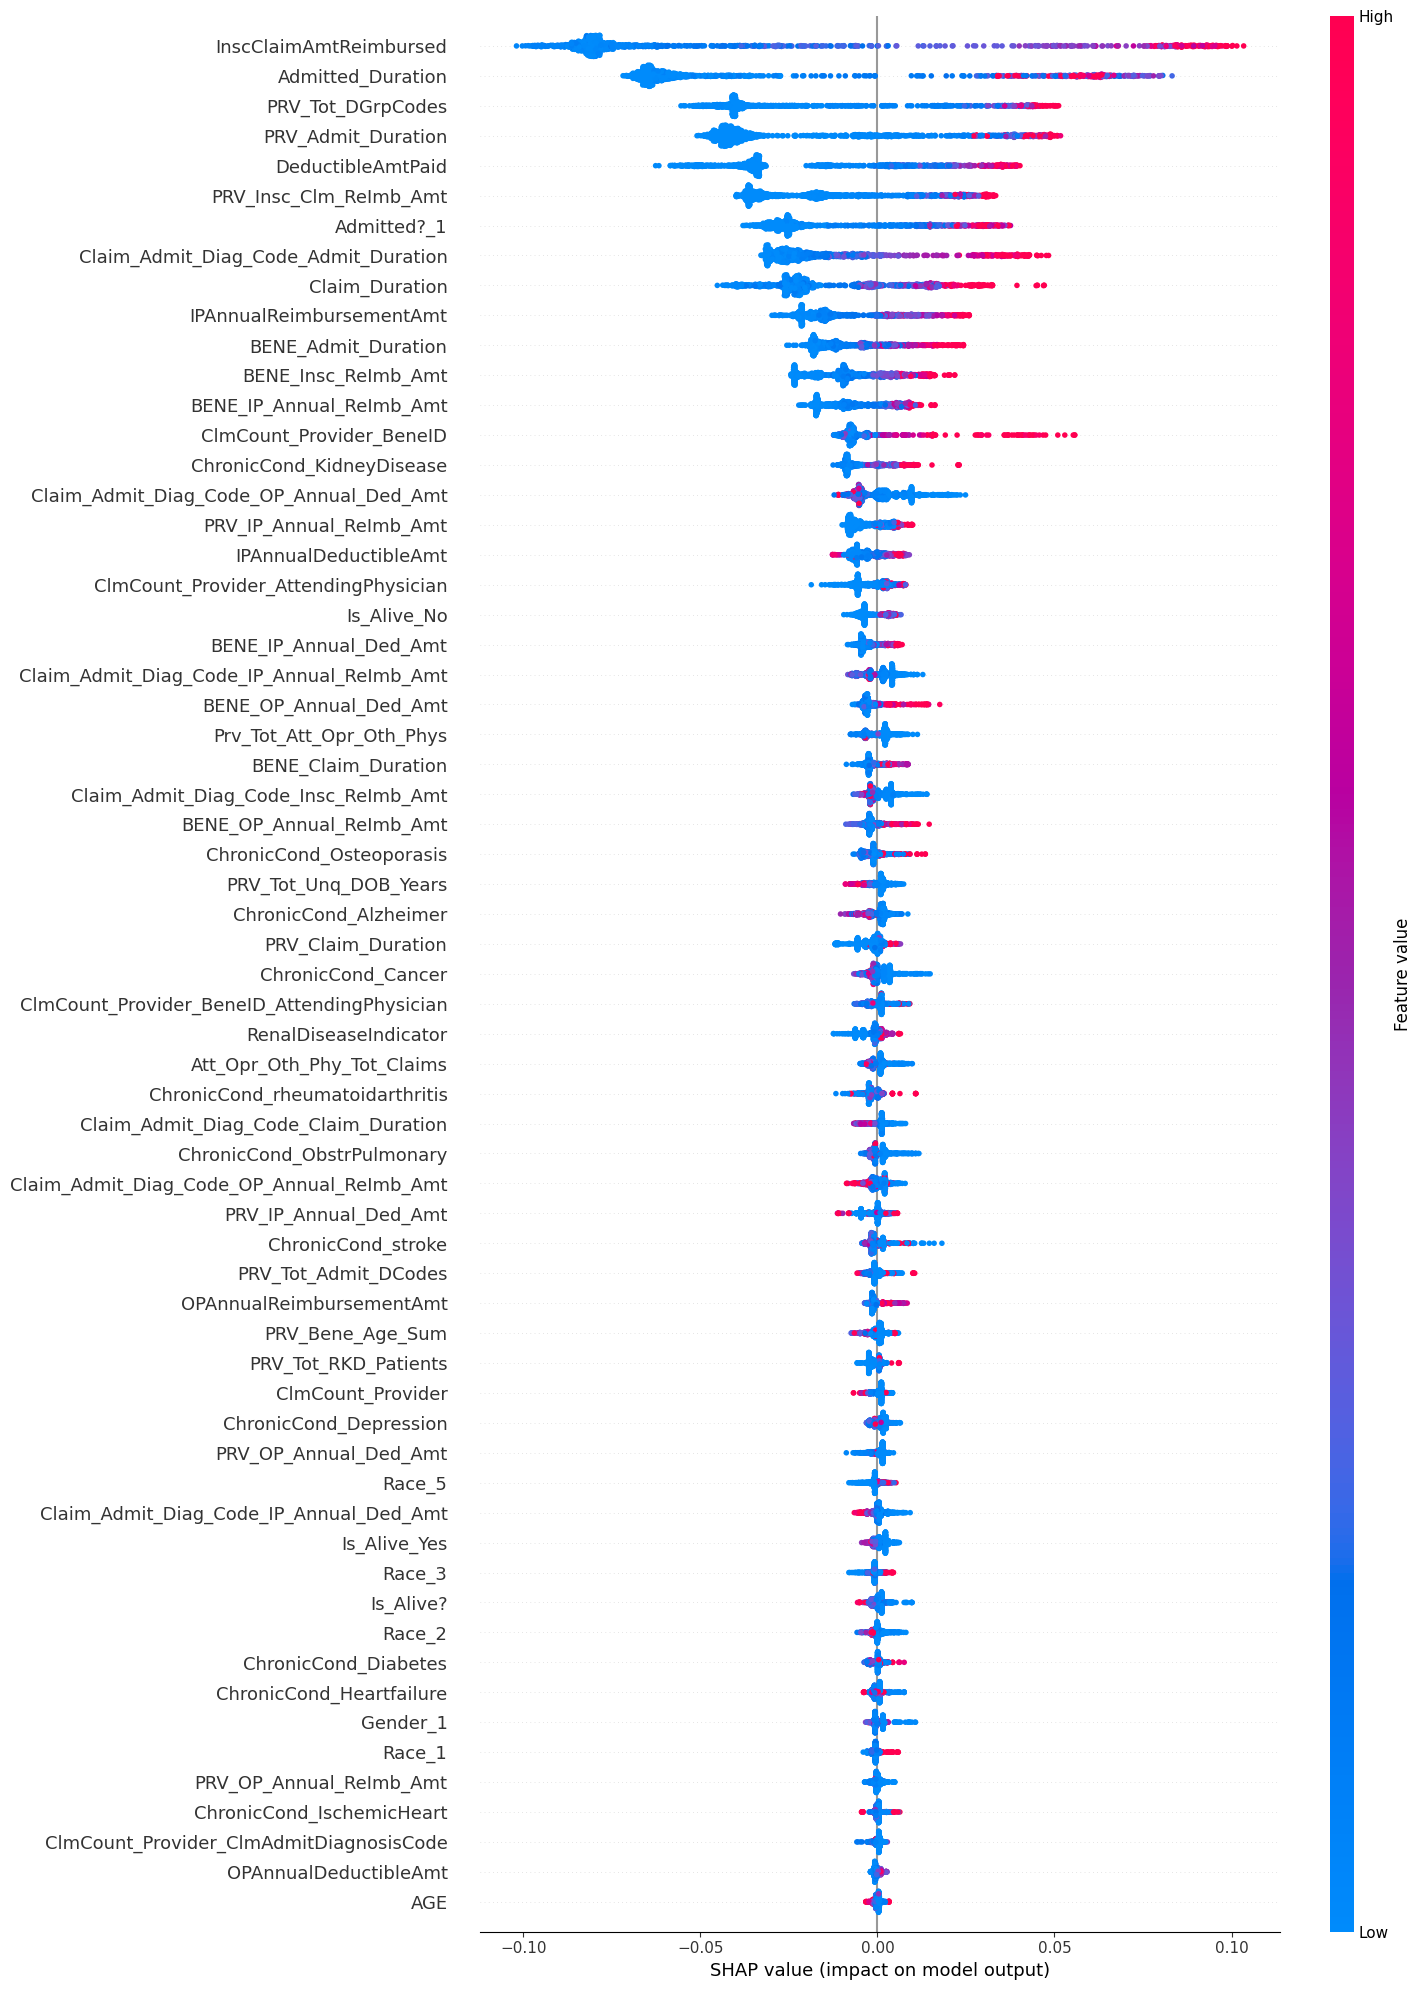

In [45]:
explainer = shap.TreeExplainer(best_rf_model)

X_sample = X_train_ovsamp.sample(200, random_state=42)
explainer = shap.TreeExplainer(best_rf_model, X_sample)

shap_values = explainer.shap_values(X_test_std)

if not isinstance(X_test_std, pd.DataFrame):
    X_test_std = pd.DataFrame(X_test_std, columns=X_train_ovsamp.columns)

shap_values_class1 = shap_values[:, :, 1]
expected_value_class1 = explainer.expected_value[1]
shap.summary_plot(shap_values_class1, X_test_std, max_display=70, plot_size=(15, 20))

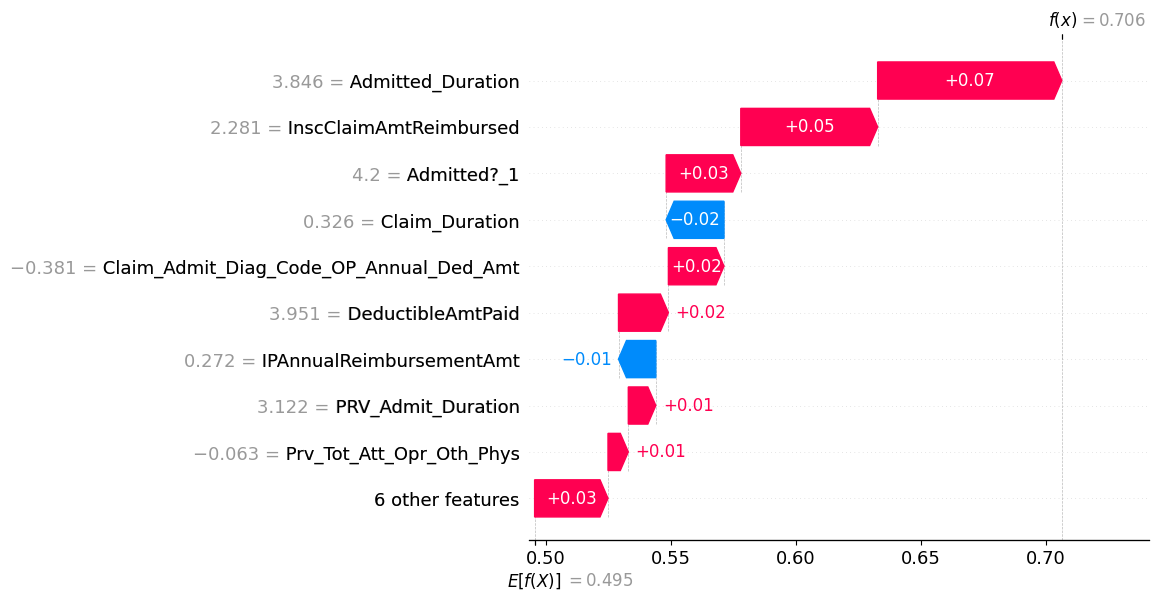

In [50]:
i = 0
max_feats = 15

full_exp = shap.Explanation(
    values=shap_values_class1[i],
    base_values=expected_value_class1,
    data=X_test_std.iloc[i],
    feature_names=X_test_std.columns
)

top_idxs = np.argsort(np.abs(full_exp.values))[-max_feats:]
top_exp = full_exp[top_idxs]

plt.figure(figsize=(10, 6))
shap.plots.waterfall(top_exp)

In [51]:
shap.initjs()

shap.force_plot(
    base_value=expected_value_class1,
    shap_values=shap_values_class1[i],
    features=X_test_std.iloc[i],
    feature_names=X_test_std.columns
)

In [58]:
shap.force_plot(
    base_value=expected_value_class1,
    shap_values=shap_values_class1[:100],
    features=X_test_std.iloc[:100],
    feature_names=X_test_std.columns,
    matplotlib=False
)

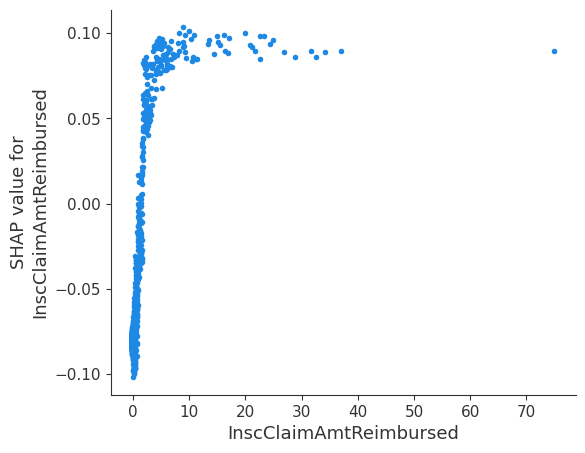

In [55]:
shap.dependence_plot(
    "InscClaimAmtReimbursed", 
    shap_values_class1,
    X_test_std,
    interaction_index=None
)